In [1]:
# 필요 라이브러리
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font', family='Arial Unicode MS')
import numpy as np
from ultralytics import YOLO
import tensorflow as tf

In [2]:
# Efficient Net 모델 불러오기
chosung_en = tf.keras.models.load_model("chosung_en.h5")
jungsung_en = tf.keras.models.load_model("jungsung_en.h5")
jongsung_en = tf.keras.models.load_model("jongsung_en.h5")

# ResNet 모델 불러오기
chosung_resnet = tf.keras.models.load_model("chosung_res.h5")
jungsung_resnet = tf.keras.models.load_model("jungsung_res.h5")
jongsung_resnet = tf.keras.models.load_model("jongsung_res.h5")

# YOLOv8n model
yolo = YOLO('best.pt')

In [13]:
# Test 이미지를 텐서 전처리 해주는 함수
def preprocess_image(img):
    img = tf.image.resize(img, [64, 64])
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [14]:
class hangeul_ocr:
    def __init__(self, image_url):
        self.image_url = image_url

    def ocr(self):

        results = yolo(self.image_url)

        # box 좌표 구하기
        boxes = results[0].boxes
        xyxy = []
        for box in boxes :
            xyxy_tmp = box.xyxy.cpu().detach().numpy().tolist()
            xyxy.append(xyxy_tmp)

        # x좌표 기준으로 나열
        xyxy.sort()

        image = Image.open(self.image_url)

        # 이미지 보여주기
        fig = plt.figure()

        plt.imshow(image)

        final_pred=[]

        for i in range(len(xyxy)): # 인식한 글자 사진

            # 박스 좌표를 토대로 이미지 가져오고 텐서 처리
            image_crop = image.crop((xyxy[i][0][0],xyxy[i][0][1],xyxy[i][0][2],xyxy[i][0][3]))
            processed_image_test = preprocess_image(image_crop)
            test_image = tf.convert_to_tensor(processed_image_test)

            # 이미지를 모델에 넣을 수 있도록 형태를 변경
            test_image = tf.expand_dims(processed_image_test, axis=0)

            # 초,중,종성 모델 두개의 확률 계산
            chosung_probabilities_1 = chosung_en.predict(test_image,verbose=0)
            jungsung_probabilities_1 = jungsung_en.predict(test_image,verbose=0)
            jongsung_probabilities_1 = jongsung_en.predict(test_image,verbose=0)

            chosung_probabilities_2 = chosung_resnet.predict(test_image,verbose=0)
            jungsung_probabilities_2 = jungsung_resnet.predict(test_image,verbose=0)
            jongsung_probabilities_2 = jongsung_resnet.predict(test_image,verbose=0)

            # 두 모델을 블렌딩한 확률 반환
            chosung_class = np.argmax(chosung_probabilities_1 * 0.5 + chosung_probabilities_2 * 0.5)
            jungsung_class = np.argmax(jungsung_probabilities_1 * 0.5 + jungsung_probabilities_2 * 0.5)
            jongsung_class = np.argmax(jongsung_probabilities_1 * 0.53 + jongsung_probabilities_2 * 0.47)

            #한글 유니코드 계산
            final = chr(chosung_class*21*28 + jungsung_class*28 + jongsung_class +44032)

            #최종 글자 리스트에 저장
            final_pred.append(final)

        #리스트에서 글자 불러오기
        result=''
        for i in final_pred:
            result+=i

        plt.title(f'Prediction : {result}')

        plt.xticks([])
        plt.yticks([])

        plt.show()


image 1/1 /Users/gyol/Documents/ds_study/DL_project/thanks.jpeg: 224x640 10 texts, 30.1ms
Speed: 1.0ms preprocess, 30.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)


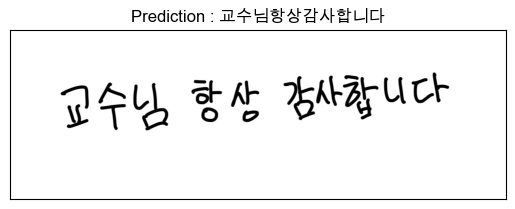

In [15]:
url = hangeul_ocr('thanks.jpeg')

url.ocr()